## TP4 - Accélération du code BEM pour l’équation de Helmholtz 2D
### Étape 2 : condition d’admissibilité

In [74]:
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import scipy.integrate as integrate
from scipy.special import roots_legendre, jv, hankel1
import time
from functools import partial

%matplotlib inline
plt.rcParams['figure.dpi']= 100

### Classe Noeud pour arbre boites

In [75]:
class NoeudCluster:
    def __init__(self):
        # Arbre de clusters (BSP)
        self.gauche = None
        self.droit = None
        self.est_feuille = False

        self.points = None          # Points contenus dans ce nœud (si feuille)
        self.indices = None         # Indices globaux des points
        self.boite = None           # (min_coords, max_coords)
        self.axe_division = None    # Axe de division (0 pour x, 1 pour y)
        self.coord_division = None  # Coordonnée de coupure (optionnel)

        self.profondeur = 0
        self.nb_points = 0          # Nombre de points dans le nœud


class NoeudBloc:
    def __init__(self, tau, sigma):
        # tau et sigma sont des NoeudCluster
        self.tau = tau
        self.sigma = sigma

        self.est_feuille = False    # Feuille dans l'arbre de blocs ?
        self.admissible = False     # Bloc admissible ou non

        # Enfants (4 sous-blocs)
        self.gauche = None          # tau.gauche x sigma.gauche
        self.droit = None           # tau.gauche x sigma.droit
        self.droite_bas = None      # tau.droit  x sigma.gauche
        self.bas_droite = None      # tau.droit  x sigma.droit

### Diamètre boite

In [76]:
def calculer_diametre_boite(boite):
    if boite is None:
        return 0.0
    min_coords, max_coords = boite
    etendues = max_coords - min_coords
    dist_sq = np.sum(etendues**2)
    return np.sqrt(dist_sq)

### Distance entre boites

In [77]:
def distance_entre_boites(boite_A, boite_B):
    if boite_A is None or boite_B is None:
        return np.inf # Pas de distance définissable

    min_A, max_A = boite_A
    min_B, max_B = boite_B

    delta = np.maximum(0.0, np.maximum(min_A - max_B, min_B - max_A))
    dist = np.linalg.norm(delta)

    return dist

### Critère admissibilité boites

In [78]:
def is_admissible(noeud1,noeud2,eta):
    boite1 = noeud1.boite
    boite2 = noeud2.boite
    if boite1 is None or boite2 is None:
        return False
    diam1 = calculer_diametre_boite(boite1)
    diam2 = calculer_diametre_boite(boite2)
    minimum = min(diam1,diam2)
    distance = distance_entre_boites(boite1,boite2)
    if distance < 1e-15:
        return False
    boolean = (minimum < eta * distance)
    return boolean

### Construction arbre boites

In [107]:
def construire_arbre_bsp(points, indices_originaux, Nleaf=5, profondeur=0):
    noeud = NoeudCluster()
    noeud.profondeur = profondeur

    N = len(points)
    noeud.nb_points = N

    if N == 0:
        noeud.est_feuille = True
        noeud.points = np.empty((0, 2))
        noeud.indices = np.array([], dtype=int)
        noeud.boite = None
        return noeud

    noeud.indices = np.array(indices_originaux, dtype=int)

    min_coords = np.min(points, axis=0)
    max_coords = np.max(points, axis=0)
    noeud.boite = (min_coords, max_coords)

    if N <= Nleaf:
        noeud.est_feuille = True
        noeud.points = points
        return noeud

    etendues = max_coords - min_coords
    noeud.axe_division = int(np.argmax(etendues))

    # Méthode de la médiane
    coords_sur_axe = points[:, noeud.axe_division]
    idx_median = N // 2
    perm = np.argpartition(coords_sur_axe, idx_median)

    left_idx_local = perm[:idx_median]
    right_idx_local = perm[idx_median:]

    points_gauche = points[left_idx_local]
    points_droit = points[right_idx_local]

    indices_gauche_originaux = noeud.indices[left_idx_local]
    indices_droit_originaux = noeud.indices[right_idx_local]

    # # Méthode géométrique
    # noeud.coord_division = min_coords[noeud.axe_division] + etendues[noeud.axe_division] / 2.0


    # masque_gauche = points[:, noeud.axe_division] <= noeud.coord_division
    # masque_droit = ~masque_gauche

    # if np.sum(masque_gauche) == 0 or np.sum(masque_droit) == 0:
    #     noeud.est_feuille = True
    #     noeud.points = points
    #     return noeud

    # points_gauche = points[masque_gauche]
    # points_droit = points[masque_droit]

    # indices_gauche_originaux = noeud.indices[masque_gauche]
    # indices_droit_originaux = noeud.indices[masque_droit]


    if len(points_gauche) == 0 or len(points_droit) == 0:
        noeud.est_feuille = True
        noeud.points = points
        return noeud

    noeud.gauche = construire_arbre_bsp(points_gauche, indices_gauche_originaux,
                                        Nleaf, profondeur + 1)
    noeud.droit = construire_arbre_bsp(points_droit, indices_droit_originaux,
                                       Nleaf, profondeur + 1)
    return noeud


def get_max_profondeur(noeud):
    if noeud is None or noeud.est_feuille:
        return noeud.profondeur if noeud else 0

    prof_gauche = get_max_profondeur(noeud.gauche) if noeud.gauche else noeud.profondeur
    prof_droit = get_max_profondeur(noeud.droit) if noeud.droit else noeud.profondeur
    
    return max(prof_gauche, prof_droit)

### Construction arbre blocs

In [80]:
def construire_arbre_blocs(noeud_tau, noeud_sigma, eta=3):
    bloc = NoeudBloc(noeud_tau, noeud_sigma)

    if is_admissible(noeud_tau, noeud_sigma, eta):
        bloc.est_feuille = True
        bloc.admissible = True
        return bloc

    if noeud_tau.est_feuille or noeud_sigma.est_feuille:
        bloc.est_feuille = True
        bloc.admissible = False
        return bloc

    bloc.gauche = construire_arbre_blocs(noeud_tau.gauche, noeud_sigma.gauche, eta)
    bloc.droit = construire_arbre_blocs(noeud_tau.gauche, noeud_sigma.droit, eta)
    bloc.droite_bas = construire_arbre_blocs(noeud_tau.droit, noeud_sigma.gauche, eta)
    bloc.bas_droite = construire_arbre_blocs(noeud_tau.droit, noeud_sigma.droit, eta)

    return bloc

### Dessin arbre bloc

In [81]:
def dessiner_blocs(ax, bloc, x_pos, y_pos):
    """
    Dessine récursivement l'arbre de blocs sur l'axe (x,y),
    avec x = colonnes (sigma), y = lignes (tau).
    """
    taille_x = bloc.sigma.nb_points   # nb de colonnes
    taille_y = bloc.tau.nb_points     # nb de lignes

    if bloc.est_feuille:
        # Couleur selon admissible / non admissible
        couleur = 'green' if bloc.admissible else 'red'
        rect = patches.Rectangle(
            (x_pos, y_pos),
            taille_x,
            taille_y,
            linewidth=0.5,
            edgecolor='black',
            facecolor=couleur,
            alpha=0.7
        )
        ax.add_patch(rect)
        return

    # Nœud interne : on dessine récursivement les 4 enfants
    bloc_gg = bloc.gauche       # tau.gauche x sigma.gauche
    bloc_gd = bloc.droit        # tau.gauche x sigma.droit
    bloc_dg = bloc.droite_bas   # tau.droit  x sigma.gauche
    bloc_dd = bloc.bas_droite   # tau.droit  x sigma.droit

    # Tailles du bloc en haut à gauche (gauche-gauche)
    taille_x_gauche = bloc_gg.sigma.nb_points
    taille_y_gauche = bloc_gg.tau.nb_points

    # 1) Haut-gauche
    dessiner_blocs(ax, bloc_gg, x_pos, y_pos)

    # 2) Haut-droite
    new_x = x_pos + taille_x_gauche
    dessiner_blocs(ax, bloc_gd, new_x, y_pos)

    # 3) Bas-gauche
    new_y = y_pos + taille_y_gauche
    dessiner_blocs(ax, bloc_dg, x_pos, new_y)

    # 4) Bas-droite
    dessiner_blocs(ax, bloc_dd, new_x, new_y)


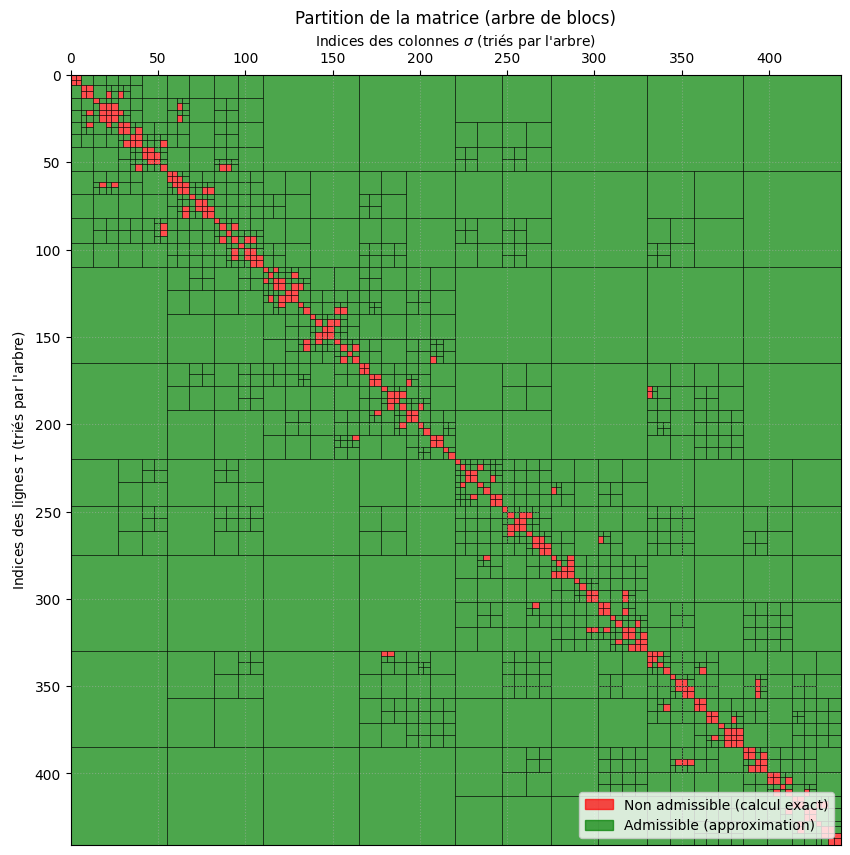

In [ ]:
np.random.seed(50)

# # Géométrie 1 : 2 clusters bien séparés pour un joli visuel

# N_points_par_cluster = 200
# N = N_points_par_cluster * 2

# cluster_1 = np.random.rand(N_points_par_cluster, 2)
# cluster_1[:, 0] += 0.5 # Décalage

# cluster_2 = np.random.rand(N_points_par_cluster, 2)
# cluster_2[:, 0] += 2.5 # Décalé loin sur l'axe X

# tous_les_points = np.vstack([cluster_1, cluster_2])
# indices_originaux = np.arange(N)

# Géométrie 2 : maillage régulier

N = 20
dx = 1 / N
dy = 1 / N
tous_les_points = np.array([(i*dx, j*dy) for i in range(N) for j in range(N)])
indices_originaux = np.arange(N * N)

# Construction arbre de clusters
racine_clusters = construire_arbre_bsp(tous_les_points, indices_originaux, Nleaf=5)

# Construction arbre de blocs
eta = 3
racine_blocs = construire_arbre_blocs(racine_clusters, racine_clusters, eta)

fig, ax = plt.subplots(figsize=(10, 10))

# Dessin de l'arbre de blocs
dessiner_blocs(ax, racine_blocs, x_pos=0, y_pos=0)

# Configuration du graphe (taille = nombre total de DOFs)
taille_totale = racine_clusters.nb_points
ax.set_xlim(0, taille_totale)
ax.set_ylim(0, taille_totale)
ax.invert_yaxis()
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')

ax.set_xlabel("Indices des colonnes $\\sigma$ (triés par l'arbre)")
ax.set_ylabel("Indices des lignes $\\tau$ (triés par l'arbre)")
ax.set_title("Partition de la matrice (arbre de blocs)")

ax.set_aspect('equal')

legende_patches = [
    patches.Patch(color='red', alpha=0.7, label='Non admissible (calcul exact)'),
    patches.Patch(color='green', alpha=0.7, label='Admissible (approximation)')
]
ax.legend(handles=legende_patches, loc='lower right')

plt.grid(True, linestyle=':', alpha=0.5)
plt.show()

Plus paramètre $\eta$ grand, plus les blocs sont admissibles, excepté sur la diagonale

### Matrice BEM

In [83]:
def generate_nodes(N, a):
    angles = np.linspace(0, 2*np.pi, N, endpoint=False)
    x = a * np.cos(angles)
    y = a * np.sin(angles)
    return angles, np.column_stack((x, y))

def generate_segments_indices(N):
    return [(k, (k+1) % N) for k in range(N)]

def uInc(x,y,k):
    return np.exp(-1j*k*x)

def G(n1,n2,k):
    x1,y1 = n1
    x2,y2 = n2
    z1 = x1 + 1j*y1
    z2 = x2 + 1j*y2
    dist = np.abs(z2-z1)
    if dist < 1e-15:
        return 0 # G(x,x) est infini, géré séparément
    return 1j*hankel1(0,k*dist)/4

def GaussLegendre(f,a,b,points,poids):
    n = len(points)
    x, w = points, poids
    S = 0.0
    for i in range(n):
        t = x[i]
        u = (b-a)/2*t + (b+a)/2
        S += w[i]*f(u)
    return (b-a)/2*S

def integrale2D(f,n1,n2,points,poids): 
    x1,y1 = n1[0],n1[1]
    x2,y2 = n2[0],n2[1]
    norm = np.sqrt((x2-x1)**2 + (y2-y1)**2)
    def g(t):
        X = x1*(1-t)+x2*t
        Y = y1*(1-t)+y2*t
        return f(X,Y)*norm
    return GaussLegendre(g,0,1,points,poids)

def matriceA(N,segments,nodes,G_func,points,poids,k):
    A = np.zeros((N,N),dtype=np.complex128)
    for i in range(N): # Segments "ex" (observation)
        seg_i_n1 = nodes[i]
        seg_i_n2 = nodes[(i+1)%N]
        
        for j in range(N): # Segments "ey" (source)
            seg_j_n1 = nodes[j]
            seg_j_n2 = nodes[(j+1)%N]

            if i==j:
                coeff = -1/(2*np.pi)
                
                # Coordonnées des nœuds du segment
                x1, y1 = seg_j_n1
                x2, y2 = seg_j_n2
                long = np.sqrt((x2-x1)**2 + (y2-y1)**2)

                # Fonctions de distance
                d_j = lambda x,y: np.sqrt((x1-x)**2 + (y1-y)**2)
                d_j_plus_1 = lambda x,y: np.sqrt((x2-x)
                                                 **2 + (y2-y)**2)
                
                # Partie singulière (intégrale analytique de log|x-y|)
                f = lambda x,y: coeff * (
                    d_j_plus_1(x,y) * np.log(d_j_plus_1(x,y) + 1e-15) + 
                    d_j(x,y) * np.log(d_j(x,y) + 1e-15) - long
                )
                A[i][j] += integrale2D(f, seg_i_n1, seg_i_n2, points, poids)

                # Partie régulière
                const = 1j/4 + coeff*(np.log(k/2)+np.euler_gamma)
                # Intégrale de la constante 1 (longueur du segment j)
                long_j = integrale2D(lambda x,y: 1.0, seg_j_n1, seg_j_n2, points, poids)
                # On intègre cette constante sur le segment i
                A[i][j] += integrale2D(lambda x,y: const * long_j, seg_i_n1, seg_i_n2, points, poids)
            
            else:
                # Double intégrale régulière
                I_inner = lambda X,Y: integrale2D(
                    lambda x,y: G_func((x,y),(X,Y),k), 
                    seg_i_n1, seg_i_n2, points, poids
                )
                A[i][j] += integrale2D(I_inner, seg_j_n1, seg_j_n2, points, poids)
    return A

### Calculs explicits sous-blocs admissibles de la matrice bem et vérification low-rank

In [84]:
def trouver_blocs_admissibles(noeud_tau,noeud_sigma,eta=3):

    blocs_admissibles = []

    if is_admissible(noeud_tau, noeud_sigma, eta):
        blocs_admissibles.append((noeud_tau,noeud_sigma))

    elif noeud_tau.est_feuille or noeud_sigma.est_feuille:
        pass

    else :
        blocs_admissibles.extend(trouver_blocs_admissibles(noeud_tau.gauche, noeud_sigma.gauche, eta))
        blocs_admissibles.extend(trouver_blocs_admissibles(noeud_tau.gauche, noeud_sigma.droit, eta))
        blocs_admissibles.extend(trouver_blocs_admissibles(noeud_tau.droit, noeud_sigma.droit, eta))
        blocs_admissibles.extend(trouver_blocs_admissibles(noeud_tau.droit, noeud_sigma.gauche, eta))

    return blocs_admissibles

--- Test du plus grand bloc admissible ---
Taille du bloc (lignes x cols): 25 x 25


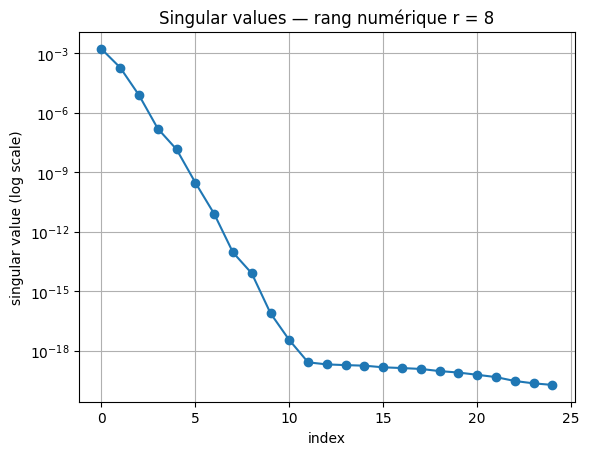

In [ ]:
Nsegments = 200         # Nombre de noeuds/segments
a = 1.0         # Rayon
k = 2 * np.pi   # Nombre d'onde
n_gauss = 2     # Points de Gauss-Legendre

# --- Initialisation BEM ---
angles, nodes = generate_nodes(Nsegments, a)
segments = generate_segments_indices(Nsegments)
points, poids = np.polynomial.legendre.leggauss(n_gauss)

# matrice BEM
BEM = matriceA(Nsegments, segments, nodes, G, points, poids, k)

# Géométrie compatible avec la BEM : les points = les centres/noeuds de la frontière
tous_les_points = nodes
indices_originaux = np.arange(Nsegments)

# arbre binaire
racine_binaire = construire_arbre_bsp(tous_les_points, indices_originaux)

# arbre de blocs
racine_blocs = construire_arbre_blocs(racine_binaire,racine_binaire)

# liste des blocs admissibles
blocs_admissibles = trouver_blocs_admissibles(racine_binaire,racine_binaire)
m = len(blocs_admissibles)

if m == 0:
    raise RuntimeError("Aucun bloc admissible trouvé. Vérifiez Nleaf et eta.")

def get_min_size(bloc_tuple):
    tau, sigma = bloc_tuple
    return min(tau.nb_points, sigma.nb_points)

blocs_tries = sorted(blocs_admissibles, key=get_min_size, reverse=True)

bloc_tau, bloc_sigma = blocs_tries[0] 

print(f"--- Test du plus grand bloc admissible ---")
print(f"Taille du bloc (lignes x cols): {bloc_tau.nb_points} x {bloc_sigma.nb_points}")

indices_ligne = np.sort(bloc_tau.indices)
indices_colonne = np.sort(bloc_sigma.indices)

# Vérifier que les indices ne sont pas vides
if len(indices_ligne) == 0 or len(indices_colonne) == 0:
    raise RuntimeError(f"Le bloc {bloc_tau.nb_points}x{bloc_sigma.nb_points} a des indices vides.")
sous_blocsBEM = BEM[np.ix_(indices_ligne, indices_colonne)]
if sous_blocsBEM.size == 0:
    raise RuntimeError("Sous-bloc vide")
U, S, Vh = np.linalg.svd(sous_blocsBEM, full_matrices=False)
tol = 1e-12 * max(sous_blocsBEM.shape) * S[0]
rang_num = np.sum(S > tol)
plt.semilogy(S, marker='o')
plt.title(f"Singular values — rang numérique r = {rang_num}")
plt.xlabel("index")
plt.ylabel("singular value (log scale)")
plt.grid(True)
plt.show()

a utilisé l'ia pour pouvoir trier rapidement les blocs pour trouver les gros